In [1]:
import json
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def evaluate_and_plot_mlp(
    model_path: str,
    norms_json: str,
    hidden_dims: list[int],
    activations: list[str],
    test_csv: str,
    sample_index: int = None
):
    # ─── 0) Load saved norms ────────────────────────────────────────────────────
    with open(norms_json, 'r') as f:
        norms = json.load(f)
    # target normalization
    y_mean = np.array(norms['y_mean'], dtype=np.float32)
    y_std  = np.array(norms['y_std'],  dtype=np.float32)
    # feature normalization
    feat_mean = norms['x_mean']   # dict: {num_col_name: mean}
    feat_std  = norms['x_std']    # dict: {num_col_name: std}

    # ─── 1) Load test data & true outputs ─────────────────────────────────────
    df = pd.read_csv(test_csv)
    output_cols = df.columns[:2].tolist()
    y_true = df[output_cols].to_numpy(dtype=np.float32)

    # ─── 2) Normalize numeric inputs ──────────────────────────────────────────
    numeric_inputs = list(feat_mean.keys())
    df_num = df[numeric_inputs].astype(float).copy()
    for c in numeric_inputs:
        df_num[c] = (df_num[c] - feat_mean[c]) / feat_std[c]

    # ─── 3) One‐hot encode the last (3-way) categorical column ────────────────
    cat_col = df.columns[-1]
    df_dum = pd.get_dummies(df[cat_col], prefix=cat_col)

    # ─── 4) Build full feature matrix & align columns ────────────────────────
    feature_names = numeric_inputs + df_dum.columns.tolist()
    X_full = pd.concat([df_num, df_dum], axis=1)
    # ensure exact column order and fill any missing with 0
    X      = X_full.reindex(columns=feature_names, fill_value=0)
    X_np   = X.to_numpy(dtype=np.float32)

    # ─── 5) Define the same 2-output MLP architecture ────────────────────────
    class MLPNet(nn.Module):
        def __init__(self, in_dim, hidden_dims, activations, out_dim):
            super().__init__()
            layers, dims = [], [in_dim] + hidden_dims
            for i, h in enumerate(hidden_dims):
                layers.append(nn.Linear(dims[i], dims[i+1]))
                act = activations[i].lower()
                if   act=='relu':     layers.append(nn.ReLU())
                elif act=='tanh':     layers.append(nn.Tanh())
                elif act=='sigmoid':  layers.append(nn.Sigmoid())
                elif act=='softplus': layers.append(nn.Softplus())
                else: raise ValueError(f"Unknown activation '{activations[i]}'")
            layers.append(nn.Linear(dims[-1], out_dim))
            self.net = nn.Sequential(*layers)
        def forward(self, x):
            return self.net(x)

    # ─── 6) Load model weights ───────────────────────────────────────────────
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = MLPNet(
        in_dim      = X_np.shape[1],
        hidden_dims = hidden_dims,
        activations = activations,
        out_dim     = y_true.shape[1]
    ).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # ─── 7) Predict & un‐normalize ───────────────────────────────────────────
    with torch.no_grad():
        y_pred_norm = model(torch.from_numpy(X_np).to(device)).cpu().numpy()
    y_pred = y_pred_norm * y_std + y_mean

    # ─── 8) Compute and print R² ─────────────────────────────────────────────
    r2_vals = r2_score(y_true, y_pred, multioutput='raw_values')
    r2_avg  = r2_score(y_true, y_pred)
    print(
        f"R² per output: "
        f"{output_cols[0]}={r2_vals[0]:.4f}, "
        f"{output_cols[1]}={r2_vals[1]:.4f}    "
        f"(avg={r2_avg:.4f})"
    )

    # ─── 9) Error histogram ─────────────────────────────────────────────────
    plt.figure(figsize=(8,5))
    for i, col in enumerate(output_cols):
        errs = y_pred[:,i] - y_true[:,i]
        plt.hist(errs, bins=30, alpha=0.6, edgecolor='k', label=col)
    plt.title("Prediction Error Histogram")
    plt.xlabel("Predicted − True")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ─── 10) True vs Predicted scatter ──────────────────────────────────────
    fig, axs = plt.subplots(1, len(output_cols), figsize=(6*len(output_cols), 6))
    if len(output_cols) == 2:
        axs = axs.flatten()
    for i, col in enumerate(output_cols):
        ax = axs[i]
        ax.scatter(y_true[:,i], y_pred[:,i], alpha=0.6)
        mn, mx = (
            min(y_true[:,i].min(), y_pred[:,i].min()),
            max(y_true[:,i].max(), y_pred[:,i].max())
        )
        ax.plot([mn, mx], [mn, mx], 'k--')
        ax.set_title(f"True vs Predicted ({col})")
        ax.set_xlabel("True")
        ax.set_ylabel("Predicted")
        # optional highlight
        if sample_index is not None and 0 <= sample_index < len(y_true):
            ax.scatter(
                [y_true[sample_index, i]],
                [y_pred[sample_index, i]],
                color='red', s=80,
                label=f"Sample {sample_index}"
            )
            ax.legend()
    plt.tight_layout()
    plt.show()


R² per output: BOE_Prodoction_2 year cum=0.7898, BOE_Production_6mon cum=0.7259    (avg=0.7579)


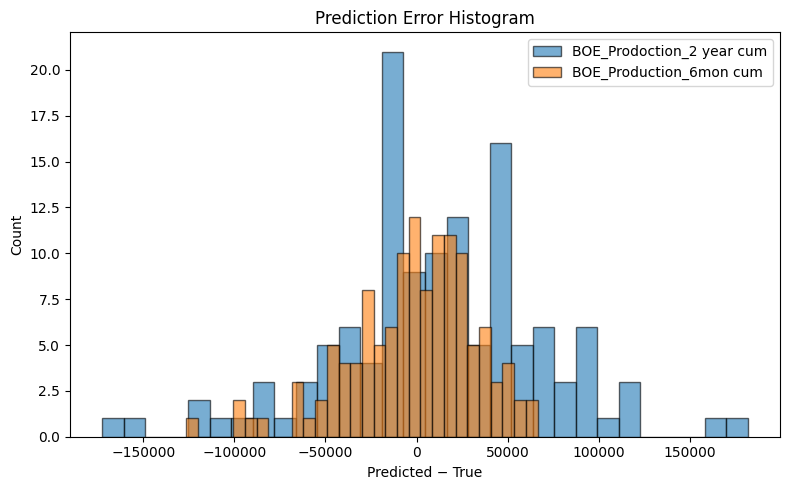

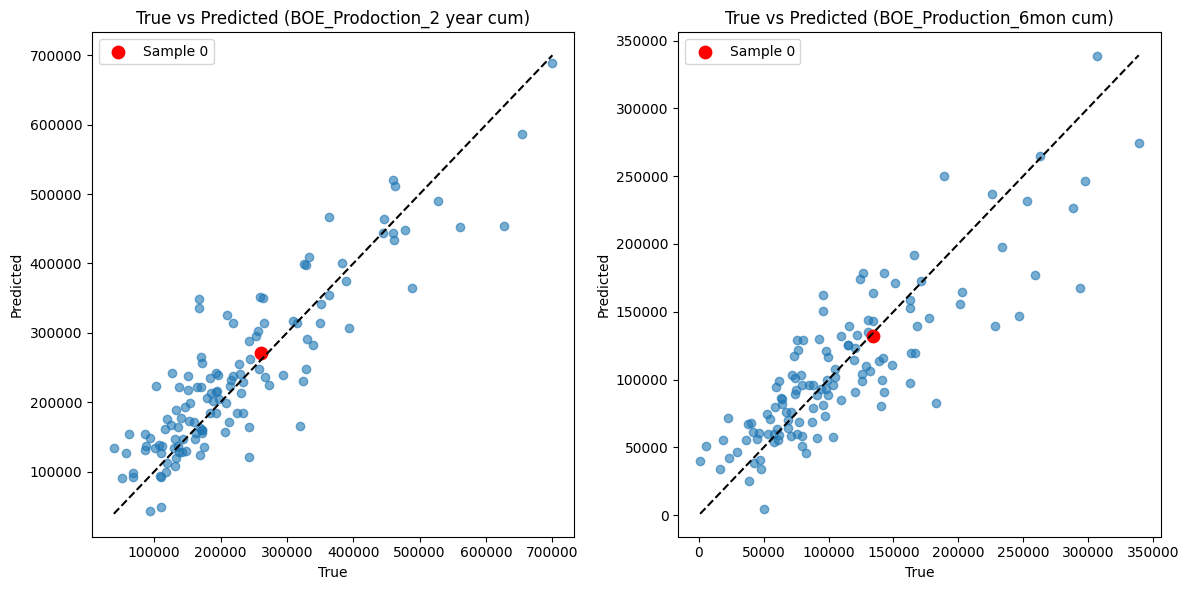

In [2]:
evaluate_and_plot_mlp(
    model_path   = "/home/kamiar/chevron/Eagle-Ford/First/606d04aa/606d04aa_fold6.pth",
    norms_json   = "/home/kamiar/chevron/Eagle-Ford/First/606d04aa/606d04aa_norms.json",
    hidden_dims  = [128, 128],
    activations  = ['tanh','relu','relu'],
    test_csv     = "/home/kamiar/chevron/Eagle-Ford/First/data/Eagle Ford Data(Eagle Ford)_test.csv",
    sample_index = 0
)